# 01. Data Preprocessing
This notebook prepares the resume and job description data for the semantic similarity model.  
It includes cleaning, normalizing, and saving the processed text for embedding.

In [21]:
!pip install pandas numpy scikit-learn nltk tqdm

## Import Libraries

In [22]:
import pandas as pd
import re
import string
import html
import numpy as np
import nltk
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from pathlib import Path
import matplotlib.pyplot as plt

In [23]:
# Download the necessary tokenizers and language data
nltk.download('punkt')
nltk.download('punkt_tab') 
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/tamtran/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/tamtran/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tamtran/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/tamtran/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Load Datasets

In [24]:
#Merge jobs data from multiple sources and clean them

adzuna_path_1 = Path("../data/adzunajobs_raw_data_1.csv")
adzuna_path_2 = Path("../data/adzunajobs_raw_data_2.csv")
adzuna_path_3 = Path("../data/adzunajobs_raw_data_3.csv")
usajobs_path = Path("../data/usajobs_raw_data.csv")
merged_path = Path("../data/full_jobs_data.csv")

# Read both datasets
adzuna_df_1 = pd.read_csv(adzuna_path_1)
adzuna_df_2 = pd.read_csv(adzuna_path_2)
adzuna_df_3 = pd.read_csv(adzuna_path_3)
usajobs_df = pd.read_csv(usajobs_path)

# Combine (ignore index so it re-numbers)
combined_df = pd.concat([adzuna_df_1, adzuna_df_2, adzuna_df_3, usajobs_df], ignore_index=True)
# Drop duplicates just in case (use relevant columns)
combined_df.drop_duplicates(subset=["title", "company", "location"], inplace=True)

# Save the merged file
combined_df.to_csv(merged_path, index=False)

print(f"Merged {len(combined_df)} total jobs and saved to {merged_path}")


Merged 11734 total jobs and saved to ../data/full_jobs_data.csv


In [25]:
# Load resume and job description data
resumes = pd.read_csv('../data/Resume.csv')
jobs = pd.read_csv('../data/full_jobs_data.csv')  
print(jobs.columns)
print(jobs.iloc[0])

# Show structure
resumes.head(), jobs.head()

Index(['source', 'id', 'title', 'company', 'location', 'description', 'url',
       'salary_min', 'salary_max', 'date_posted'],
      dtype='object')
source                                                    Adzuna
id                                                    5489721046
title                  Software Engineer–Developer (Development)
company                                                   BOEING
location                             Kinloch, Saint Louis County
description    Job Description At Boeing, we innovate and col...
url            https://www.adzuna.com/land/ad/5489721046?se=G...
salary_min                                             166350.06
salary_max                                             166350.06
date_posted                                 2025-11-10T14:12:17Z
Name: 0, dtype: object


(         ID                                         Resume_str  \
 0  16852973           HR ADMINISTRATOR/MARKETING ASSOCIATE\...   
 1  22323967           HR SPECIALIST, US HR OPERATIONS      ...   
 2  33176873           HR DIRECTOR       Summary      Over 2...   
 3  27018550           HR SPECIALIST       Summary    Dedica...   
 4  17812897           HR MANAGER         Skill Highlights  ...   
 
                                          Resume_html Category  
 0  <div class="fontsize fontface vmargins hmargin...       HR  
 1  <div class="fontsize fontface vmargins hmargin...       HR  
 2  <div class="fontsize fontface vmargins hmargin...       HR  
 3  <div class="fontsize fontface vmargins hmargin...       HR  
 4  <div class="fontsize fontface vmargins hmargin...       HR  ,
    source          id                                      title  \
 0  Adzuna  5489721046  Software Engineer–Developer (Development)   
 1  Adzuna  5435062476              Business Development Director  

### Check Columns

In [26]:
print("Resume columns:", resumes.columns)
print("Job dataset columns:", jobs.columns)

Resume columns: Index(['ID', 'Resume_str', 'Resume_html', 'Category'], dtype='object')
Job dataset columns: Index(['source', 'id', 'title', 'company', 'location', 'description', 'url',
       'salary_min', 'salary_max', 'date_posted'],
      dtype='object')


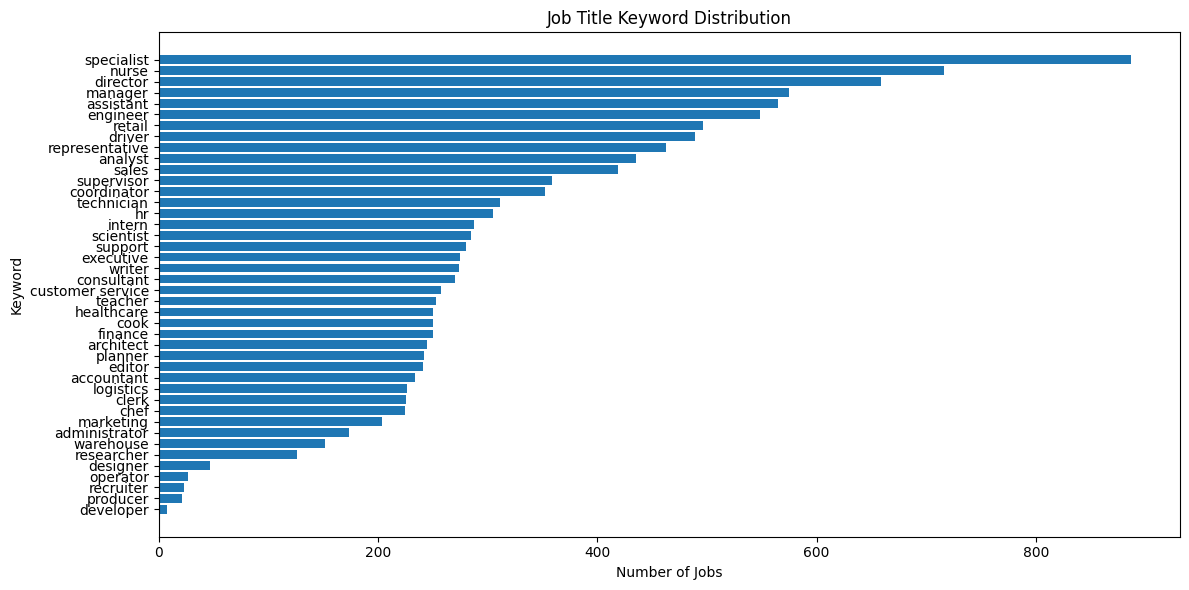

In [27]:
# Define the list of keywords
keywords = [
    "developer", "engineer", "scientist", "analyst", "manager",
    "technician", "designer", "assistant", "intern", "consultant",
    "teacher", "sales", "marketing", "finance", "healthcare", "nurse",
    "driver", "operator", "administrator", "coordinator", "specialist",
    "supervisor", "director", "executive", "clerk", "representative",
    "hr", "recruiter", "accountant", "architect", "planner",
    "researcher", "writer", "editor", "producer", "chef", "cook",
    "warehouse", "logistics", "customer service", "support", "retail",
]

# Count how many job titles contain each keyword
title_counts = {k: jobs['title'].str.contains(k, case=False, na=False).sum() for k in keywords}

# Create a dataframe of counts
df_counts = pd.DataFrame(list(title_counts.items()), columns=['Keyword', 'Count']).sort_values('Count', ascending=False)

# Plot a horizontal bar chart
plt.figure(figsize=(12,6))
plt.barh(df_counts['Keyword'], df_counts['Count'])
plt.xlabel('Number of Jobs')
plt.ylabel('Keyword')
plt.title('Job Title Keyword Distribution')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Text Cleaning Function

In [28]:
tqdm.pandas()
jobs.columns = jobs.columns.str.strip().str.lower().str.replace(' ', '_')

# Handle missing values if any
resumes.dropna(subset=['Resume_str'], inplace=True)
jobs.dropna(subset=['description'], inplace=True)

# --- Clean and Normalize Text ---
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# (1) For embeddings — fully normalized text
def clean_text_for_model(text):
    if not isinstance(text, str):
        return ""
    text = html.unescape(text)
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"\S+@\S+", "", text)
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(r"\d+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\s+", " ", text).strip()
    tokens = [lemmatizer.lemmatize(w) for w in text.split() if w not in stop_words and len(w) > 2]
    return " ".join(tokens)

# (2) For display — keep punctuation for readability
def clean_text_for_display(text):
    if not isinstance(text, str):
        return ""
    text = html.unescape(text)
    text = re.sub(r"\s+", " ", text.strip())
    sentences = [s.strip().capitalize() for s in text.split(".") if s]
    return ". ".join(sentences)

## Apply Cleaning

In [30]:
# Apply both cleaning styles
resumes['clean_resume'] = resumes['Resume_str'].progress_apply(clean_text_for_model)
resumes['clean_resume_display'] = resumes['Resume_str'].progress_apply(clean_text_for_display)

jobs['clean_job'] = jobs['description'].progress_apply(clean_text_for_model)
jobs['clean_job_display'] = jobs['description'].progress_apply(clean_text_for_display)

print("Created both cleaned and readable text columns!")

100%|██████████| 11734/11734 [00:00<00:00, 72235.45it/s]

Created both cleaned and readable text columns!


## Save clean data

In [31]:
DATA_DIR = (Path.cwd() / "../data").resolve()
DATA_DIR.mkdir(parents=True, exist_ok=True)

# Save cleaned datasets
resumes.to_csv(DATA_DIR / "cleaned_resumes_for_model.csv", index=False)
jobs.to_csv(DATA_DIR / "cleaned_jobs_for_model.csv", index=False)
resumes.to_csv(DATA_DIR / "cleaned_resumes_full.csv", index=False)
jobs.to_csv(DATA_DIR / "cleaned_jobs_full.csv", index=False)

print(f"\nFiles saved successfully in {DATA_DIR}:")
print(f"cleaned_resumes_for_model.csv")
print(f"cleaned_jobs_for_model.csv")
print(f"cleaned_resumes_full.csv")
print(f"cleaned_jobs_full.csv")


Files saved successfully in /Users/tamtran/Desktop/Desktop/CalPolyPomona/Fall2025/cs4200-final-project/resume_job_match/data:
cleaned_resumes_for_model.csv
cleaned_jobs_for_model.csv
cleaned_resumes_full.csv
cleaned_jobs_full.csv


### Notes:
This notebook is used for the data preprocessing stage of both the resume and job description datasets. It focuses on cleaning, normalizing, and preparing the text for semantic similarity modeling.
- Imported and verified all required libraries and datasets.
- Handled missing values and standardized column names.
- Implemented two cleaning functions:
    - `clean_text_for_model()` - removed HTML tags, links, punctuation, numbers, and stopwords; lemmatized tokens for embedding-ready text.
    - `clean_text_for_display()` - retained punctuation and capitalization for human-readable output.
- Applied both cleaning styles to the datasets and generated corresponding columns.
- Saved the processed datasets `(cleaned_resumes_for_model.csv`, `cleaned_jobs_for_model.csv`, and full readable versions) for downstream embedding and similarity analysis.

## Dataset

The resume dataset was obtained from [Kaggle](https://www.kaggle.com/datasets/pranavvenugo/resume-and-job-description), and the job description dataset was fetched from Adzuna.

